# Okay... so... 

Change which agents you choose partner from


-> also... ........ Vary it for downstream analysis?

In [2]:
# Model design
import agentpy as ap
import numpy as np

# Visualization
import seaborn as sns
import pandas as pd

import scipy.stats
import datetime
import matplotlib.pyplot as plt

from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# utility functions

### setup_p_txns

In [3]:
DEBUG = False

def setup_p_txns(total_steps):
    # Mean at 0
    max_std_devs = 5 # 

    if DEBUG:
        # Note: scipy norm has stddev = 1, mean of 0
        # Below shows why we pick max_std_devs = 5
        p_txn = scipy.integrate.quad(
                scipy.stats.norm.pdf, -5, 5)[0] # quad() Returns: value, error
        print('In total we will capture this amount of the gaussian: ', p_txn)
    
    txn_probabilities = np.ones(total_steps) * -1

    std_dev_per_step = 2 * max_std_devs / total_steps

    for step in range(total_steps):
        p_txn = \
            scipy.integrate.quad(
                scipy.stats.norm.pdf, 
                -max_std_devs + step * std_dev_per_step, 
                -max_std_devs + (step+1) * std_dev_per_step
            ) # returns: (integration) value, error
        txn_probabilities[step] = p_txn[0]
        if DEBUG:
            print(step, p_txn[0])
    # The peak should be at 0, not halfway through)
    zeroing_shift = int(np.round(txn_probabilities.shape[0] / 2))
    shifted = np.concatenate(
            (txn_probabilities[-zeroing_shift:], 
            txn_probabilities[:-zeroing_shift]))

    if False:
        # DEBUG: In txn time plot,
        # Should see peaks exactly at the means for each type of agent
        txn_probabilities[0] = 1 # set p_txn to 1 to always transact
        txn_probabilities[1:-1] = 0.01 # or Zero

    return shifted 

# agent

In [4]:
            #n_agents = len(self.agents.select(self.agents.condition == i))

In [5]:
class BankAgent(ap.Agent):
    def setup(self):
        self.txn_amt_rng = None 
        self.txn_probabilities = None 
        self.type = None 
        self.acct_balance = None 
        self.mean_txns = 4
        self.send_txn_times = []

        self.txns = None
        self.txns_list = []
        self.txn_amts = None

    def setup_txn_amts(self, mean=100, stddev=10, total_steps=0):
        self.txn_amts = self.txn_amt_rng.normal(
            loc=mean, scale=stddev, 
            size=total_steps)

    # NOTE: Timesteps start at 1
    # TODO: fix bug. where first timestep should be at midnight.
    # TODO: fix so stored txn time can be timestep, not timestep-1
    # TOOD: issue currently is graph has both midnight 10/31 and midngith 11/1
    # TODO: due to resample rounding up or down or something idk
    def transact(self, timestep):
        # using as index, subtract (timestep starts at 1)
        p_txn = self.txn_probabilities[timestep-1] * self.mean_txns

        if np.random.random() < p_txn and self.acct_balance > 0:
            # using as value, do nothing
            self.send_txn_times.append(timestep) 
            # randomly choose partner
            my_partner = self.model.agents.random() # we get a list back
            my_partner = my_partner.to_list()[0] 
            # randomly choose amount
            amount = self.txn_amts[timestep-1]

            # calculations
            my_partner.acct_balance += amount
            self.acct_balance -= amount

            if DEBUG:
                print(
                    f' Transaction @ step: {timestep} with ptxn: {p_txn:.2f}, '
                    f'${amount:.2f} from: {self.id}->{my_partner.id}, '
                    f'({self.type} to {my_partner.type}), new balance: {self.acct_balance:.1f}'
                )

            # Note that txn_type is redundant info (e.g. can be derived from +/- of amount)
            self.txns_list.append([ timestep, 'send', self.id, self.type,
                my_partner.id, my_partner.type, -amount, self.acct_balance])

            my_partner.txns_list.append([
                timestep, 'receive', self.id, self.type, my_partner.id, my_partner.type, amount, my_partner.acct_balance])

    def cleanup(self):
        self.txns = pd.DataFrame(self.txns_list,
            columns=['timestep', 'txn_type', 'sender_id', 'sender_type', 
            'receiver_id', 'receiver_type', 'amount', 'acct_balance',] )

# parameters

In [6]:
# set up agent type txn
#     'network_randomness': 0.5
#     'number_of_neighbors': 2,
AGENT_TYPE_START_FRIENDS = {
    'normal': '5',
    'suspicious': '2'
}

AGENT_TYPE_NEW_FRIENDS = {
    'normal': '0.5',
    'suspicious': '0.5'
}

AGENT_TYPE_PAIR_PROBS = {
    'normal': { 
        'self': 0.9, 
        'suspicious': 0.1
    },
    'suspicious': {
        'self': 0.8,
        'normal': 0.2
    }
}

NUM_AGENTS_PER_TYPE = {

    'normal': 100,
    'suspicious': 10, 
}

MEAN_TXN_HRS = {'normal':14, 
                'suspicious':22}

MINS_PER_STEP = 15

MEAN_TXN_AMOUNTS = {'normal':250, 
                'suspicious':50}

parameters = {
    'num_agents_per_type': NUM_AGENTS_PER_TYPE,
    'mean_txn_hrs': MEAN_TXN_HRS,
    'mean_txn_amounts ': MEAN_TXN_AMOUNTS,
    'mean_txns': 4, # avg num txns each agent makes
    'starting_balance': 100,
    'seed': 42,
    'mins_per_step' : MINS_PER_STEP, # 1 hr
    'steps': int(24 * (60/MINS_PER_STEP)), # 24 hours * steps per hr
}

# For plotting
def timestep_to_time(timestep):
    date_and_time = datetime.datetime(2022, 10, 31, 0, 0, 0)
    time_elapsed = timestep * (parameters['mins_per_step'])
    time_change = datetime.timedelta(minutes=time_elapsed)
    new_time = date_and_time + time_change
    return new_time

# scratch

# model

In [7]:
class BankModel(ap.Model):
    def setup(self):
        self.p_txns = setup_p_txns(self.p.steps) 
        num_agents = sum(self.p.num_agents_per_type.values())
        
        # Setup up rng to generate seeds for rngs for agents
        rng = np.random.default_rng(self.p.seed)
        agent_rng_seeds = rng.random(num_agents).round(3) * 1000
        agent_rng_seeds = np.array(agent_rng_seeds, dtype=int)

        self.agents = ap.AgentList(self) 
        # -- shift the tables 
        for type in ['normal', 'suspicious']:
            hrs_mean = self.p.mean_txn_hrs[type]
            # shift in steps
            # originally peak at 0, now peak at (mean time)
            shift_amt = hrs_mean * int(60 / self.p.mins_per_step)
            shifted = np.concatenate(
                (self.p_txns[-shift_amt:], self.p_txns[:-shift_amt]))
            agents = ap.AgentList(
                self, self.p.num_agents_per_type[type], BankAgent)

            agents.txn_probabilities = shifted
            agents.total_steps = self.p.steps 
            agents.acct_balance = 100
            agents.type = type

            self.agents += agents

        if DEBUG:
            print('here are all the agetns: ')
            print(self.agents)
            print([(agent.id,agent.type) for agent in self.agents])

        # calcuations for txn values
        txn_amt_rngs = ap.AttrIter(
            [np.random.default_rng(seed) for seed in agent_rng_seeds])
        self.agents.txn_amt_rng = txn_amt_rngs

        for agent in self.agents:
            agent.setup_txn_amts(
                mean=20, stddev=5, total_steps=self.p.steps)

    def step(self):
        self.agents.transact(self.t)

    def update(self):
        pass
        '''
        if DEBUG:
            total_txns = 0
            for agent in self.agents:
                num_txns = agent.txns[agent.txns.txn_type == 'send'].shape[0]
                total_txns += num_txns
            print('num txns (across all agents)', total_txns)
        '''

    def end(self):
        # i think this includes the final timestep t = 96 as entire column
        self.agents.record('send_txn_times')
        
        # export data
        for agent in self.agents:
            agent.cleanup()

# scratch

In [8]:
# https://github.com/JoelForamitti/agentpy/blob/master/tests/test_sequences.py
tmp_model = BankModel()
agents = ap.AgentList(tmp_model, 10, BankAgent)
agents.random(5).type = 'test'
agents.id
for agent in agents:
    print(agent.id, agent.type)
agents.select(agents.type=='test').random().id

1 None
2 None
3 None
4 test
5 test
6 None
7 test
8 None
9 test
10 test


[7]

In [9]:
np.random.default_rng(42).normal()

0.30471707975443135

# run

In [10]:
model = BankModel(parameters)
results = model.run()

Completed: 96 steps
Run time: 0:00:00.135821
Simulation finished


# Plot

In [11]:
# For plotting
def timestep_to_time(timestep):
    date_and_time = datetime.datetime(2022, 10, 31, 0, 0, 0)
    time_elapsed = timestep * (parameters['mins_per_step'])
    time_change = datetime.timedelta(minutes=time_elapsed)
    new_time = date_and_time + time_change
    return new_time

In [12]:
if DEBUG:
    for agent in model.agents:
        print(agent.txns)
display(model.agents[0].txns)

,timestep,txn_type,sender_id,sender_type,receiver_id,receiver_type,amount,acct_balance
0,41,receive,57,normal,1,normal,23.418918,123.418918
1,49,send,1,normal,13,normal,-24.072471,99.346447
2,57,receive,25,normal,1,normal,27.832149,127.178597
3,58,receive,53,normal,1,normal,19.478544,146.657141
4,59,send,1,normal,104,suspicious,-19.744455,126.912686
5,60,send,1,normal,17,normal,-13.156018,113.756668
6,62,receive,36,normal,1,normal,8.729972,122.486640
7,70,receive,47,normal,1,normal,27.902366,150.389006


In [13]:
# transaction amount, sender, receiver, timestamp

In [14]:
results.info

{'model_type': 'BankModel',
 'time_stamp': '2022-12-11 11:35:07',
 'agentpy_version': '0.1.5',
 'python_version': '3.10.',
 'experiment': False,
 'completed': True,
 'created_objects': 110,
 'completed_steps': 96,
 'run_time': '0:00:00.135821'}

In [15]:
# okay so now i want to... uh... okay histogram plot of when txns are occuring
# then i want to ... make a network of who transacted with who

In [16]:
if DEBUG:
    model.agents.acct_balance

In [17]:
#sns.histplot(model.agents.acct_balance)
model.agents[0].txns#.where('txn_type
model.agents.txns.shape
#model.agents.txns[1]

[(8, 8), (8, 8), (7, 8), (4, 8), (6, 8), (9, 8), (5, 8), (11, 8), (13, 8), (12, 8), (14, 8), (10, 8), (9, 8), (7, 8), (11, 8), (9, 8), (10, 8), (10, 8), (4, 8), (11, 8), (10, 8), (10, 8), (4, 8), (6, 8), (10, 8), (7, 8), (7, 8), (13, 8), (12, 8), (9, 8), (10, 8), (10, 8), (5, 8), (8, 8), (7, 8), (10, 8), (6, 8), (8, 8), (2, 8), (4, 8), (6, 8), (5, 8), (8, 8), (8, 8), (3, 8), (6, 8), (9, 8), (7, 8), (11, 8), (8, 8), (5, 8), (10, 8), (5, 8), (5, 8), (12, 8), (8, 8), (6, 8), (9, 8), (9, 8), (8, 8), (8, 8), (2, 8), (9, 8), (5, 8), (7, 8), (6, 8), (4, 8), (6, 8), (8, 8), (7, 8), (8, 8), (8, 8), (6, 8), (5, 8), (10, 8), (5, 8), (8, 8), (7, 8), (4, 8), (7, 8), (8, 8), (9, 8), (6, 8), (9, 8), (9, 8), (7, 8), (6, 8), (8, 8), (8, 8), (8, 8), (5, 8), (8, 8), (10, 8), (7, 8), (4, 8), (8, 8), (6, 8), (12, 8), (7, 8), (4, 8), (7, 8), (7, 8), (4, 8), (10, 8), (6, 8), (5, 8), (5, 8), (8, 8), (9, 8), (6, 8)]

In [18]:
all_txns = []
for agent in model.agents:
    #print(agent.id, 'with txns at timesteps: ',  agent.send_txn_times)
    #print('aka times: ') 

    for timestamp in agent.send_txn_times:
        #print( timestep_to_time(timestamp).strftime('%H:%M'))
        all_txns.append(timestep_to_time(timestamp))
    #print('the partners were: ', agent.txns[agent.txns.txn_type =='send'].receiver_id)
all_txns = pd.DataFrame( all_txns, columns=['send_txn_times' ])
all_txns.sort_values(by='send_txn_times')

,send_txn_times
406,2022-10-31 00:15:00
399,2022-10-31 00:15:00
375,2022-10-31 00:15:00
390,2022-10-31 00:30:00
395,2022-10-31 00:45:00
...,...
400,2022-10-31 23:15:00
411,2022-10-31 23:45:00
405,2022-11-01 00:00:00
394,2022-11-01 00:00:00


In [19]:
with np.printoptions(precision=3, suppress=True):
    display(model.agents[0].txn_probabilities)

array([0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.001, 0.001, 0.001, 0.001, 0.002, 0.002, 0.003, 0.003, 0.004,
       0.005, 0.006, 0.008, 0.009, 0.011, 0.013, 0.015, 0.018, 0.02 ,
       0.023, 0.025, 0.028, 0.031, 0.033, 0.035, 0.037, 0.039, 0.04 ,
       0.041, 0.041, 0.041, 0.041, 0.04 , 0.039, 0.037, 0.035, 0.033,
       0.031, 0.028, 0.025, 0.023, 0.02 , 0.018, 0.015, 0.013, 0.011,
       0.009, 0.008, 0.006, 0.005, 0.004, 0.003, 0.003, 0.002, 0.002,
       0.001, 0.001, 0.001, 0.001, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [20]:
all_txns.index = all_txns.send_txn_times
resampled = all_txns.send_txn_times.resample('15Min')#.count().plot()
#resampled = all_txns.send_txn_times.resample('1H')#.count().plot()
resampled.count()
df = pd.DataFrame(resampled.count())
df.columns=['num_txns']
df['labels'] = pd.to_datetime(df.index).strftime('%H:%M')

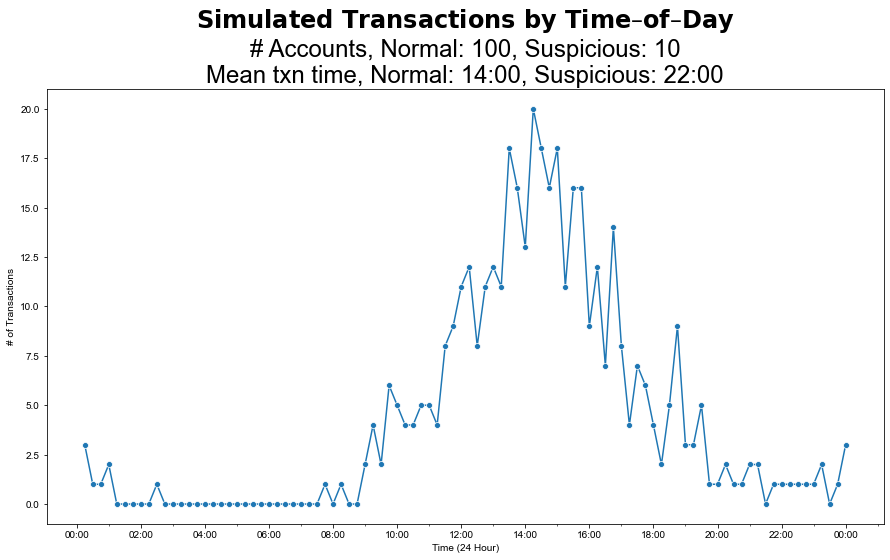

In [21]:
fig, ax = plt.subplots(figsize=(15,8))
sns.lineplot(x='send_txn_times', y='num_txns', data=df, ax=ax,
    markers=True,  marker='o')

# -- 
# format
sns.set_style('whitegrid')
sns.set_context('poster')

ax.set(xlabel='Time (24 Hour)', ylabel='# of Transactions',
# add title 
title=r"$\bf{Simulated\ Transactions\ by\ Time–of–Day}$" 
    f"\n# Accounts, Normal: {parameters['num_agents_per_type']['normal']}, "
    f"Suspicious: {parameters['num_agents_per_type']['suspicious']}\n"
    f"Mean txn time, Normal: {parameters['mean_txn_hrs']['normal']}:00,"
    f" Suspicious: {parameters['mean_txn_hrs']['suspicious']}:00"
    )

# 
ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%H:%M"))

# calculate node and edge list

# okay concentrate

In [22]:
results.variables['suspicious']

,,send_txn_times
obj_id,t,
101,96,"[1, 75, 89]"
102,96,"[70, 74, 83, 85, 87, 91]"
103,96,"[85, 90, 96]"
104,96,"[78, 82, 88]"
105,96,"[2, 10, 78, 93, 96]"
106,96,"[3, 4, 76, 81]"
107,96,"[1, 93]"
108,96,"[4, 79, 84, 92, 96]"
109,96,"[1, 71, 76, 77, 81, 95]"


In [23]:
all_txns_2 = [] 
for agent in model.agents:
    sends = agent.txns[agent.txns['txn_type'] == 'send']
    all_txns_2.append(sends)

all_txns_2[0]
df_2 = pd.concat(all_txns_2)
edges_list = df_2[['sender_id', 'receiver_id']].to_numpy()

In [24]:
import networkx as nx
#G=nx.Graph()
G=nx.DiGraph()
G.add_edges_from(edges_list)

In [25]:
G.number_of_nodes()
G.number_of_edges()

408

In [26]:
model.agents[0].type

'normal'

In [27]:
df_2 # all transcations with amts etc. 

,timestep,txn_type,sender_id,sender_type,receiver_id,receiver_type,amount,acct_balance
1,49,send,1,normal,13,normal,-24.072471,99.346447
4,59,send,1,normal,104,suspicious,-19.744455,126.912686
5,60,send,1,normal,17,normal,-13.156018,113.756668
0,49,send,2,normal,49,normal,-24.057991,75.942009
1,53,send,2,normal,35,normal,-23.502230,52.439779
...,...,...,...,...,...,...,...,...
7,81,send,109,suspicious,52,normal,-24.269552,72.513481
8,95,send,109,suspicious,34,normal,-23.883216,48.630265
2,67,send,110,suspicious,70,normal,-13.590539,133.852236
4,77,send,110,suspicious,66,normal,-14.961103,136.013456


In [28]:
df_2['timestep_to_time'] = df_2['timestep'].apply(timestep_to_time)
# for classiifcation, I want: timestamp, sender, reciver, sendertype, amount
# would be useful: if avg account balance is small overall / kept near zero

# export tabular data

In [29]:
# timestep is particular to this run, todo: refactor it out (need for 
# classification at the moment)
tabular_data = df_2[['timestep', 'timestep_to_time', 'sender_id', 'receiver_id', 'sender_type', 'amount'] ]
tabular_data.to_csv('txns_list.csv', index=False)


,timestep,timestep_to_time,sender_id,receiver_id,sender_type,amount
1,49,2022-10-31 12:15:00,1,13,normal,-24.072471
4,59,2022-10-31 14:45:00,1,104,normal,-19.744455
5,60,2022-10-31 15:00:00,1,17,normal,-13.156018
0,49,2022-10-31 12:15:00,2,49,normal,-24.057991
1,53,2022-10-31 13:15:00,2,35,normal,-23.502230
...,...,...,...,...,...,...
7,81,2022-10-31 20:15:00,109,52,suspicious,-24.269552
8,95,2022-10-31 23:45:00,109,34,suspicious,-23.883216
2,67,2022-10-31 16:45:00,110,70,suspicious,-13.590539
4,77,2022-10-31 19:15:00,110,66,suspicious,-14.961103


In [35]:
df_2[['sender_id', 'sender_type']].drop_duplicates('sender_id').to_csv('agents_list.csv', index=False)

# export network metadata

In [ ]:
G.out_degree[1]
G.in_degree[1]

5

In [ ]:
#display(pd.DataFrame(G.out_degree).head())
#display(pd.DataFrame(G.in_degree).head())
df_out_deg = pd.DataFrame(G.out_degree(), columns=['node_id', 'out_degree'])
df_in_deg = pd.DataFrame(G.in_degree(), columns=['node_id', 'in_degree'])
pd.merge(df_in_deg, df_out_deg, on='node_id' ).to_csv(
    'tabular_graph_features.csv', index=False)

In [ ]:
# in degrees and out degrees for each node
#pd.DataFrame(G.out_degree(), columns=['node_id', 'out_degree']).to_csv(
    #'tabular_graph_features.csv', index=False)

,node_id,out_degree
0,1,3
1,35,5
2,8,6
3,61,5
4,2,4
...,...,...
105,56,2
106,103,5
107,95,2
108,106,6


In [ ]:
json_data

{'data': [],
 'directed': True,
 'multigraph': False,
 'elements': {'nodes': [{'data': {'id': '1', 'value': 1, 'name': '1'}},
   {'data': {'id': '35', 'value': 35, 'name': '35'}},
   {'data': {'id': '8', 'value': 8, 'name': '8'}},
   {'data': {'id': '61', 'value': 61, 'name': '61'}},
   {'data': {'id': '2', 'value': 2, 'name': '2'}},
   {'data': {'id': '28', 'value': 28, 'name': '28'}},
   {'data': {'id': '68', 'value': 68, 'name': '68'}},
   {'data': {'id': '84', 'value': 84, 'name': '84'}},
   {'data': {'id': '30', 'value': 30, 'name': '30'}},
   {'data': {'id': '3', 'value': 3, 'name': '3'}},
   {'data': {'id': '36', 'value': 36, 'name': '36'}},
   {'data': {'id': '98', 'value': 98, 'name': '98'}},
   {'data': {'id': '7', 'value': 7, 'name': '7'}},
   {'data': {'id': '34', 'value': 34, 'name': '34'}},
   {'data': {'id': '4', 'value': 4, 'name': '4'}},
   {'data': {'id': '38', 'value': 38, 'name': '38'}},
   {'data': {'id': '54', 'value': 54, 'name': '54'}},
   {'data': {'id': '5', '

In [ ]:
#  json.dump(json_data, outfile)
# TypeError: Object of type int64 is not JSON serializable

# json does not recognize NumPy data types. Convert the number to a Python int before serializing the object:

# https://stackoverflow.com/questions/50916422/python-typeerror-object-of-type-int64-is-not-json-serializable
# json.dumps(data, default=str)
# Excellent solution. However, one drawback is that numpy arrays are returned without delimiter, e.g. '[0 1 3]'.

# export networkx graph

In [ ]:
G.out_degree()
print(type(nx.cytoscape_data(G)))
import json as json

json_data = nx.cytoscape_data(G) 
with open('exported_cytoscape_network.json', 'w', 
encoding='utf-8') as outfile: 
    outfile.write(str(json_data))

<class 'dict'>


In [ ]:
G.nodes()
[n for n in G.neighbors(1)] # 1 is the node index

colors = []
for i in range(len(G.nodes())):
    acct_type = model.agents[i].type
    G.nodes[i+1]['type'] =  model.agents[i].type
    if acct_type == 'normal' :
        colors.append('white')
    else:
        colors.append('red')

In [ ]:
G.nodes()[1]['type']

'normal'

In [ ]:
# https://memgraph.com/memgraph-for-networkx?utm_source=networkx-guide&utm_medium=referral&utm_campaign=networkx_ppp&utm_term=visualization%2Bbasics&utm_content=visualizeiteasy

# https://plotly.com/python/network-graphs/
# https://stackoverflow.com/questions/72621067/how-to-show-the-result-of-networkx-graph-in-plotly-dash-using-dash-callbacks
# https://networkx.org/documentation/networkx-1.10/reference/drawing.html

In [ ]:
edges_list
pd.DataFrame(edges_list, 
    columns=['nx_node_A', 'nx_node_B']).to_csv(
        'nx_edges_list.csv', index=False)

#np.savetxt('nx_edges_list.csv', edges_list)

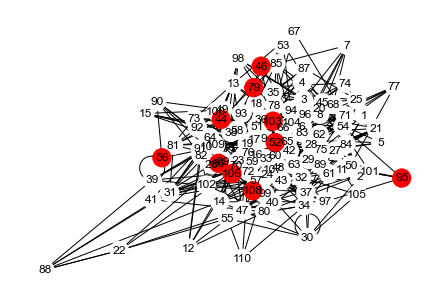

In [793]:
# https://networkx.guide/visualization/basics#layouts
#types = [ node[1]['type'] for node in G.nodes(data=True) ]
nx.draw(G, with_labels = True, node_color = colors, 
arrows=False)
#nx.draw(G, with_labels = True, node_color = colors, pos=nx.spiral_layout(G))
plt.show()

In [ ]:
#import ipycytoscape
#fig = ipycytoscape.CytoscapeWidget()
#fig.graph.add_graph_from_networkx(G)
#fig
# currently takes too long !

In [ ]:
# https://github.com/plotly/dash-cytoscape/issues/23

In [ ]:
#display(cy)

In [ ]:
# https://stackoverflow.com/questions/71428375/dash-cytoscape-from-python-networks-graph-not-honouring-the-nodes-coordinates